<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">EXPLORACIÓN DEL CONJUNTO DE DATOS PARA EL DESARROLLO DE UN SISTEMA DE RECOMENDACIÓN DE PELÍCULAS - PROYECTO MARKETING</strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### LIBRERÍAS REQUERIDAS

In [196]:
#Conexión de Google Colab con Drive.
from google.colab import drive
drive.mount('/content/drive')

#Acceder a los archivos de la carpeta marketing para el uso de funciones.
import sys
sys.path.append('/content/drive/MyDrive/marketing/Marketing')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [197]:
import pandas as pd # Manipulación y el analísis de datos.
import sqlite3 as sql # Interactuar con base de datos SQL usando Python.
import matplotlib.pyplot as plt # Creación de gráficas
import seaborn as sns # Creación de gráficas.
import plotly.express as px
from scipy import stats # Funciones estadísticas.

#### CONEXIÓN CON LA BASE DE DATOS

In [198]:
#Establece una conexión a la base de datos SQLite ubicada en "content/db_movies"
conexion = sql.connect('/content/drive/MyDrive/marketing/Marketing/data/db_movies_copy.db')

# Crear un cursor a partir de la conexión, que permita ejecutar comando SQL sobre la base de datos.
cur = conexion.cursor()

In [201]:
# Ejecuta una consulta SQL que obtiene los nombres de todas las tablas existentes en la base de datos.
cur.execute("SELECT name FROM sqlite_master where type='table' ")

# Recupera todos los resultados de la consulta anterior en forma de lista de tuplas.
cur.fetchall()

[('ratings',), ('movies',), ('ratings_movies',)]

#### ANÁLISIS EXPLORATORIO SEPARADO

##### TABLA MOVIES

In [203]:
# Ejecuta la consulta SQL "SELECT * FROM movies" sobre la base de datos y carga los resultados en un DataFrame de pandas.
table_movies = pd.read_sql_query("SELECT * FROM movies", conexion)
table_movies.head()

,movieId,año,titulo,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1995,Toy Story,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1995,Jumanji,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1995,Grumpier Old Men,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1995,Waiting to Exhale,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,1995,Father of the Bride Part II,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0




```
# Existen 5 pares de películas con duplicados por título y año.

Se  usa la consolidación basada en el título y el año de la película.
Combina esos géneros utilizando un OR lógico para crear una única
entrada que represente todos los géneros a los que pertenece la película.

Se elimina el segundo registro.
```



In [204]:
#Identificación de películas con año y título duplicado, eliminando de cada par uno
# 1. Lista de las columnas de género
columnas_genero = table_movies.columns[3:]

# 2. Diccionario para consolidar cada película
peliculas = {}

# 3. Recorremos cada fila con iterrows()
for _, fila in table_movies.iterrows():
    clave = (fila['titulo'], fila['año'])
    if clave not in peliculas:
        # Copiamos toda la fila la primera vez
        peliculas[clave] = fila.copy()
    else:
        # Hacemos OR lógico de los géneros con la fila ya guardada
        for col in columnas_genero:
            peliculas[clave][col] |= fila[col]

# 4. Reconstruimos table_movies sobrescribiéndolo
table_movies = pd.DataFrame(peliculas.values()).reset_index(drop=True)

In [205]:
#Permite guardar los cambios.
table_movies.to_sql('movies', conexion, if_exists='replace', index=False)
!ls -l /content/drive/MyDrive/marketing/Marketing/data/db_movies_copy.db
conexion.commit()

-rw------- 1 root root 9928704 May 11 18:58 /content/drive/MyDrive/marketing/Marketing/data/db_movies_copy.db


In [206]:
# Cantidad de registros duplicados para la tabla movies.
pd.read_sql_query("""
SELECT COUNT(*) - COUNT(DISTINCT movieId) AS duplicados
FROM movies
WHERE (movieId, titulo, año) IN (
    SELECT movieId, titulo, año
    FROM movies
    GROUP BY movieId, titulo, año
    HAVING COUNT(*) > 1
)
""", conexion)

,duplicados
0,0


In [207]:
# Tamaño de la tabla movies.
print(f"El tamaño de la tabla movies es de {table_movies.shape[0]} filas y {table_movies.shape[1]} columnas.")

El tamaño de la tabla movies es de 9703 filas y 22 columnas.


In [208]:
# Exploración de los tipos de datos en la tabla movies.
pd.read_sql_query("PRAGMA table_info(movies)", conexion)

,cid,name,type,notnull,dflt_value,pk
0,0,movieId,INTEGER,0,None,0
1,1,año,INTEGER,0,None,0
2,2,titulo,TEXT,0,None,0
3,3,Action,INTEGER,0,None,0
4,4,Adventure,INTEGER,0,None,0
5,5,Animation,INTEGER,0,None,0
6,6,Children,INTEGER,0,None,0
7,7,Comedy,INTEGER,0,None,0
8,8,Crime,INTEGER,0,None,0
9,9,Documentary,INTEGER,0,None,0




```
# La tabla movies de las 22 columnas, 21 son de tipo entero
y una sola de tipo texto correspondiente al nombre de las películas.

Las columnas no tiene valores nulos, no tiene un valor por defecto definida
y ninguna de las columnas tiene llaves primarias.
```



In [209]:
#Años de estreno mínimo y máximo de la tabla movies.
query = """
 SELECT
    MIN(año) AS año_minimo,
    MAX(año) AS año_maximo
FROM movies;
"""
pd.read_sql_query(query, conexion)

,año_minimo,año_maximo
0,1902,2018




```
# La película película con fecha de estreno más antiguo fue en 1902.
  La película con fecha de estreno más reciente es de 2008.
```



In [210]:
#Total de peliculas.
total = display(pd.read_sql_query("SELECT COUNT(*) AS total_movies FROM movies", conexion))

,total_movies
0,9703




```
# El total de películas es de 9703.
```



In [213]:
# Los primeros 10 años con mayor cantidad de peliculas estrenadas.
query = """
    SELECT año, COUNT(*) AS cantidad
    FROM movies
    GROUP BY año
    ORDER BY cantidad DESC
    Limit 10
"""
pd.read_sql_query(query, conexion)

,año,cantidad
0,2002,310
1,2006,295
2,2001,294
3,2007,284
4,2000,283
5,2009,282
6,2003,279
7,2014,278
8,2004,278
9,1996,274




```
# Entre 2000 y 2009 se concentraron la mayor cantidad de películas estrenadas,
durante esa década hubo una mayor actividad o disponibilidad de películas
en el conjunto de datos.

Se puede concluir que las peliculas en años recientes han caido en el
número de la producción o han estado realizandose estrenos en cantidad similares
posiblemente por el auge de las series.
```



In [214]:
query = """
SELECT año, COUNT(*) AS cantidad
FROM movies
WHERE año BETWEEN 2010 AND 2018
GROUP BY año
ORDER BY año ASC;
"""

pd.read_sql_query(query, conexion)

,año,cantidad
0,2010,247
1,2011,254
2,2012,233
3,2013,237
4,2014,278
5,2015,271
6,2016,213
7,2017,143
8,2018,42


In [215]:
# Los primeros 10 años con mayor menor cantidad de pélículas estrenadas
query = """
    SELECT año, COUNT(*) AS cantidad
    FROM movies
    GROUP BY año
    ORDER BY cantidad ASC
    Limit 10
"""
pd.read_sql_query(query, conexion)

,año,cantidad
0,1902,1
1,1903,1
2,1908,1
3,1915,1
4,1917,1
5,1919,1
6,1921,1
7,1922,1
8,1920,2
9,1916,4




```
# En los primeros años del cine (entre 1902 y 1922), hay muy pocas
películas registradas en el dataset —la mayoría con solo 1 película
por año, y el máximo de apenas 4 en 1916.
```



In [216]:
#Cantidad de películas estenadas por decada.
query ="""SELECT
  (año / 10) * 10 AS decada,
  COUNT(*) AS cantidad
FROM movies
GROUP BY decada
ORDER BY decada DESC
"""
pd.read_sql_query(query, conexion)


,decada,cantidad
0,2010,1918
1,2000,2846
2,1990,2207
3,1980,1175
4,1970,499
5,1960,400
6,1950,278
7,1940,197
8,1930,136
9,1920,37




```
# La mayoría de pelícuala están entre los años 1990 y 2009,
siendo la década de los 2000 la que más películas tiene registradas.
Aunque entre 2010 y 2019 también hay muchas, la cantidad bajó un poco.
```



In [217]:
#Gráfica - Cantidad de peliculas por año de estreno.
year_counts = table_movies['año'].value_counts().sort_index()
fig = px.bar(
    x=year_counts.index,
    y=year_counts.values,
    labels={'x': 'Year', 'y': 'Number of Movies'},
    title='Number of Movies per Year',
    color=year_counts.index
)
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Movies",
    title_x=0.5,  # Center the title
    coloraxis_showscale=True # Show the color bar
)
fig.show()


In [218]:
#Total de géneros.
total_generos = genre_counts.shape[0]
print("Total de géneros:", total_generos)

Total de géneros: 19


In [219]:
# Cantidad de generos en la tabla movies.
query = """SELECT
    SUM(Action) AS Action,
    SUM(Comedy) AS Comedy,
    SUM(Drama) AS Drama,
    SUM(Horror) AS Horror,
    SUM(Romance) AS Romance,
    SUM(Thriller) AS Thriller,
    SUM(Adventure) AS Adventure,
    SUM(Animation) AS Animation,
    SUM(Children) AS Children,
    SUM(Documentary) AS Documentary,
    SUM(Fantasy) AS Fantasy,
    SUM(IMAX) AS IMAX,
    SUM(Musical) AS Musical,
    SUM(Mystery) AS Mystery,
    SUM(War) AS War,
    SUM(Western) AS Western,
    SUM("Film-Noir") AS "Film-Noir",
    SUM("Sci-Fi") AS "Sci-Fi"


FROM movies;
"""
pd.read_sql_query(query, conexion)


,Action,Comedy,Drama,Horror,Romance,Thriller,Adventure,Animation,Children,Documentary,Fantasy,IMAX,Musical,Mystery,War,Western,Film-Noir,Sci-Fi
0,1827,3755,4359,978,1595,1892,1263,611,664,440,779,158,334,573,382,167,87,978




```
# Los géneros más frecuentes  son Drama (4359), Comedy (3755) y Action (1827)
Esto muestra que esos géneros son los más populares o los más producidos.
```



In [220]:
#Gráfica - Frecuencia por genero
genre_counts = table_movies.drop(columns=['movieId', 'titulo', 'año']).sum().sort_values(ascending=False)

fig = px.bar(
    x=genre_counts.index,
    y=genre_counts.values,
    labels={'x': 'Genre', 'y': 'Count'},
    title='Frecuencia de géneros',
    color=genre_counts.index,
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.update_layout(
    xaxis_title="Genre",
    yaxis_title="Números de películas",
    title_x=0.5,  # Center the title
    xaxis={'categoryorder':'total descending'} # Sort the bars by count
)
fig.show()





##### TABLA RATINGS

In [221]:
# Ejecuta la consulta SQL "SELECT * FROM ratings" sobre la base de datos y carga los resultados en un DataFrame de pandas.
table_ratings = pd.read_sql_query("SELECT * FROM ratings", conexion)
table_ratings.head()

,userId,movieId,rating,day,month,hour,year
0,1,1,4.0,30,7,18,2000
1,1,3,4.0,30,7,18,2000
2,1,6,4.0,30,7,18,2000
3,1,47,5.0,30,7,19,2000
4,1,50,5.0,30,7,18,2000


In [222]:
#Tamaño de la tabla ratings
print(f"El tamaño de la tabla ratings es de {table_ratings.shape[0]} filas y {table_ratings.shape[1]} columnas.")

El tamaño de la tabla ratings es de 100783 filas y 7 columnas.


In [223]:
# Exploración de los tipos de datos en la tabla ratings.
pd.read_sql_query("PRAGMA table_info(ratings)", conexion)

,cid,name,type,notnull,dflt_value,pk
0,0,userId,INTEGER,0,None,0
1,1,movieId,INTEGER,0,None,0
2,2,rating,REAL,0,None,0
3,3,day,INTEGER,0,None,0
4,4,month,INTEGER,0,None,0
5,5,hour,INTEGER,0,None,0
6,6,year,INTEGER,0,None,0




```
# La tabla ratings tiene 7 columans, 6 de ellas son tipo entero y una real.
Ninguna columna tiene registros nulos, no tienen valor por defecto definido
y tampoco llaves primarías.
```



In [224]:
# Validación de registros duplicados.
pd.read_sql_query("""
SELECT COUNT(*) - COUNT(*) AS duplicados
FROM (SELECT userId, movieId, rating, day, month, hour, year FROM ratings GROUP BY userId, movieId, rating, day, month, hour, year HAVING COUNT(*) > 1) AS duplicados
""", conexion)

,duplicados
0,0


In [225]:
#Total de calificaciones registradas.
display(pd.read_sql_query("SELECT COUNT(*) AS total_ratings FROM ratings", conexion))

,total_ratings
0,100783


In [230]:
# Porcentaje de las calificaciones con respecto al total.
query = """
SELECT rating, COUNT(*) AS total ,  ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM ratings)),2) AS percentage
FROM ratings
GROUP BY rating
ORDER BY rating DESC
"""
pd.read_sql_query(query, conexion)


,rating,total,percentage
0,5.0,13204,13.10
1,4.5,8543,8.48
2,4.0,26808,26.60
3,3.5,13128,13.03
4,3.0,20041,19.89
5,2.5,5542,5.50
6,2.0,7549,7.49
7,1.5,1791,1.78
8,1.0,2809,2.79
9,0.5,1368,1.36




```
# La mayoría de las calificaciones son altas.

El rating 4.0 es el más frecuente, con un 26.6% de las calificaciones,
seguido por 5.0 con un 13.1% y 3.0 con un 19.9%. Esto indica que,
en general, la mayoría de los usuarios parecen dar calificaciones positivas a las películas.
```



In [244]:
#Usuarios que más calificaciones han realizado.
query = """
SELECT userId, COUNT(*) AS total_ratings, ROUND(AVG(rating), 2) AS avg_rating
FROM ratings
GROUP BY userId
ORDER BY total_ratings DESC
LIMIT 5
"""
pd.read_sql_query(query, conexion)


,userId,total_ratings,avg_rating
0,414,2696,3.39
1,599,2474,2.64
2,474,2108,3.40
3,448,1862,2.85
4,274,1346,3.24


In [251]:
#Validación del año en que se realizaron las calificaciones.
query = """
SELECT userId, rating, year, titulo
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
WHERE userId = 414
ORDER BY year;
"""

df_414 = pd.read_sql_query(query, conexion)
df_414['year'].value_counts().sort_index()

,count
year,
2000,1068
2001,218
2002,263
2003,204
2004,198
2005,93
2006,89
2007,66
2008,137




```
# Al revisar más a fondo se ve que en realidad ha calificado
películas durante varios años, especialmente entre 2000 y 2005.
```



In [253]:
#Usuarios que menos calificaciones han registrado.
query = """
SELECT userId, COUNT(*) AS total_ratings, ROUND(AVG(rating), 2) AS avg_rating
FROM ratings
GROUP BY userId
ORDER BY total_ratings ASC
LIMIT 10
"""
pd.read_sql_query(query, conexion)

,userId,total_ratings,avg_rating
0,53,20,5.00
1,147,20,3.38
2,189,20,4.10
3,194,20,3.48
4,207,20,2.88
5,257,20,3.20
6,278,20,3.88
7,320,20,3.53
8,406,20,3.25
9,431,20,2.73


In [259]:
#Validación del año en que se realizaron las calificaciones.
query = """
SELECT userId, rating, year, titulo
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
WHERE userId = 189
ORDER BY year;
"""

df_414 = pd.read_sql_query(query, conexion)
df_414['year'].value_counts().sort_index()

,count
year,
2015,20




```
# Al revisar más a fondo los usuarios que menos califican,
parece que solo han estado en la plataforma muy poco tiempo
o usado la plaforma en un solo año.
```



In [261]:
# Los primeros 10 años con mayor cantidad de calificaciones.
query = """
SELECT r.year, ROUND(AVG(r.rating), 2) AS avg_rating, COUNT(*) AS total
FROM ratings r
GROUP BY r.year
ORDER BY total DESC
limit 10
"""
pd.read_sql_query(query, conexion)


,year,avg_rating,total
0,2000,3.39,10061
1,2017,3.35,8190
2,2007,3.31,7114
3,2016,3.69,6698
4,2015,3.51,6614
5,2018,3.39,6382
6,1996,3.54,6040
7,2005,3.43,5813
8,2012,3.64,4656
9,2008,3.66,4350




```
# El año 2000 fue cuando más calificaciones se hicieron (10.061), seguido por 2017 y 2007.

Aunque el  promedio de calificación en el año 2000 (3.39) no es el más alto,
2016 tiene el promedio más alto (3.69).

 En los años con menos calificaciones, los usuarios parece que fueron más selectivos o calificaron películas que les gustaron más.
 En cambio, en los años con mucha actividad, hay más variedad de opiniones y por eso el promedio es más bajo.


```



In [262]:
# Primeras 5 horas del día donde se registran más calificaciones.
query = """ SELECT hour, COUNT(*) AS cantidad
FROM ratings
GROUP BY hour
ORDER BY cantidad DESC
LIMIT 5
"""
pd.read_sql_query(query, conexion)

,hour,cantidad
0,20,6526
1,17,6340
2,21,6268
3,19,6201
4,18,5724




```
# Esto indica que los usuarios suelen calificar películas principalmente
en la tarde y noche, probablemente después de estudiar o trabajar,
cuando tienen más tiempo libre para ver películas o registrarlas.
```



In [263]:
# Los primeros 5 meses del año donde se registran más calificaciones.
query = """ SELECT month, COUNT(*) AS cantidad
FROM ratings
GROUP BY month
ORDER BY cantidad DESC
LIMIT 5
"""
pd.read_sql_query(query, conexion)

,month,cantidad
0,5,10873
1,11,9674
2,8,9070
3,3,8876
4,6,8821




```
# hay una tendencia clara de mayor participación en ciertos meses,
lo que puede deberse a factores estacionales, académicos o culturales.
```



In [138]:
#El promedio de calificación por cada género
generos = ["Comedy", "Action", "Romance", "Thriller","Adventure","Animation","Horror","War","Western", "Children", "Documentary", "Thriller","Film-Noir","Fantasy","Mystery","Drama","Sci-Fi","Musical","IMAX"]

for g in generos:
    media = df[df[g] == 1]["rating"].mean()
    print(f"Promedio de rating para {g}: {media:.2f}")


Promedio de rating para Comedy: 3.38
Promedio de rating para Action: 3.45
Promedio de rating para Romance: 3.51
Promedio de rating para Thriller: 3.49
Promedio de rating para Adventure: 3.51
Promedio de rating para Animation: 3.63
Promedio de rating para Horror: 3.26
Promedio de rating para War: 3.81
Promedio de rating para Western: 3.58
Promedio de rating para Children: 3.41
Promedio de rating para Documentary: 3.80
Promedio de rating para Thriller: 3.49
Promedio de rating para Film-Noir: 3.92
Promedio de rating para Fantasy: 3.49
Promedio de rating para Mystery: 3.63
Promedio de rating para Drama: 3.66
Promedio de rating para Sci-Fi: 3.46
Promedio de rating para Musical: 3.56
Promedio de rating para IMAX: 3.62


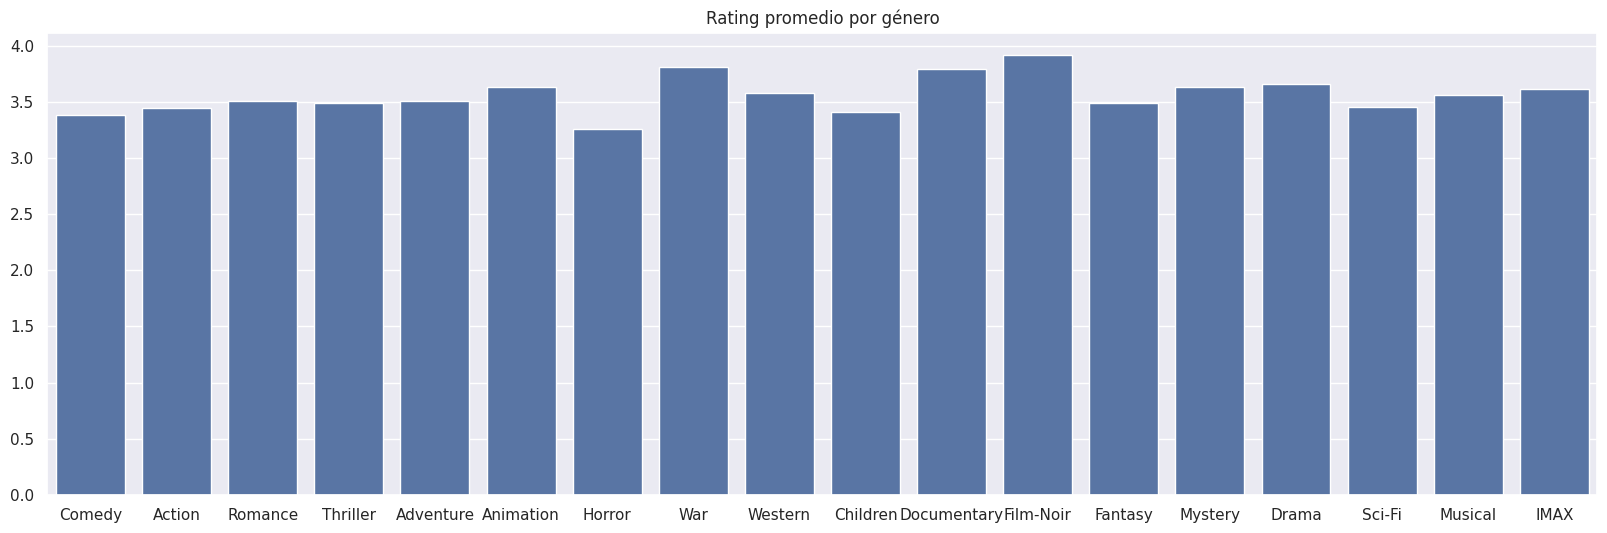

In [139]:
# Gráfica - Promedio de calificaciones por género.
plt.figure(figsize=(20, 6))
genero_promedios = {g: df[df[g] == 1]["rating"].mean() for g in generos}
sns.barplot(x=list(genero_promedios.keys()), y=list(genero_promedios.values()))
plt.title("Rating promedio por género")
plt.show()




```
# Los géneros mejor valorados por los usuarios son Film-Noir, Documental
y Guerra, mientras que Horror, Comedia y Niños reciben las calificaciones
más bajas. Esto sugiere que los usuarios tienden a apreciar más los
géneros serios o especializados que los comerciales o infantiles.
```



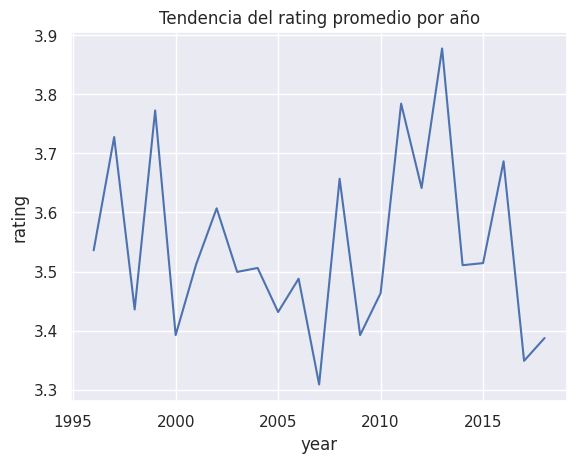

In [264]:
#Gráfica - Tendencia de las calificaciones por año.
sns.lineplot(data=df.groupby("year")["rating"].mean().reset_index(), x="year", y="rating")
plt.title("Tendencia del rating promedio por año")
plt.show()

In [265]:
# Función para gráficar histograma, boxplot y qqplot
def graficos_distribucion(df, variables):
    sns.set(style="darkgrid")

    for var in variables:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'Distribución de la variable: {var}', fontsize=16)

        # Histograma
        sns.histplot(df[var].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title('Histograma')

        # Boxplot
        sns.boxplot(x=df[var].dropna(), ax=axes[1], color='lightgreen')
        axes[1].set_title('Boxplot')

        # QQ Plot
        stats.probplot(df[var].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title('QQ Plot')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


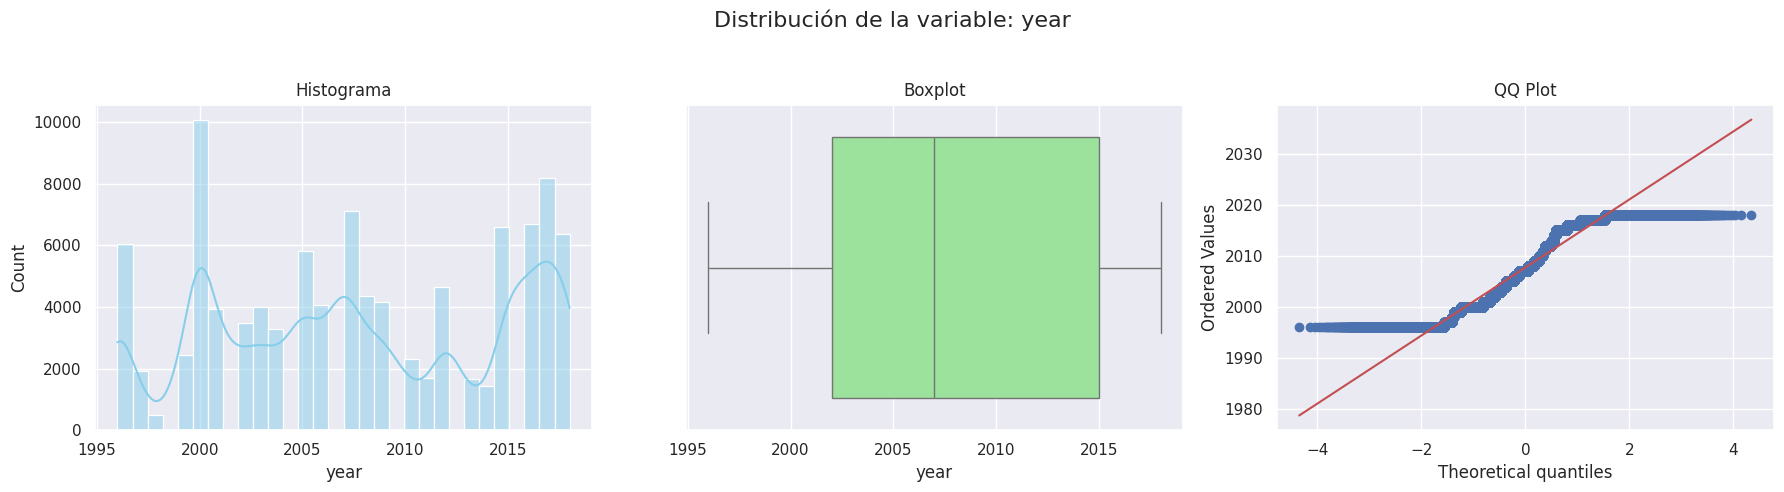

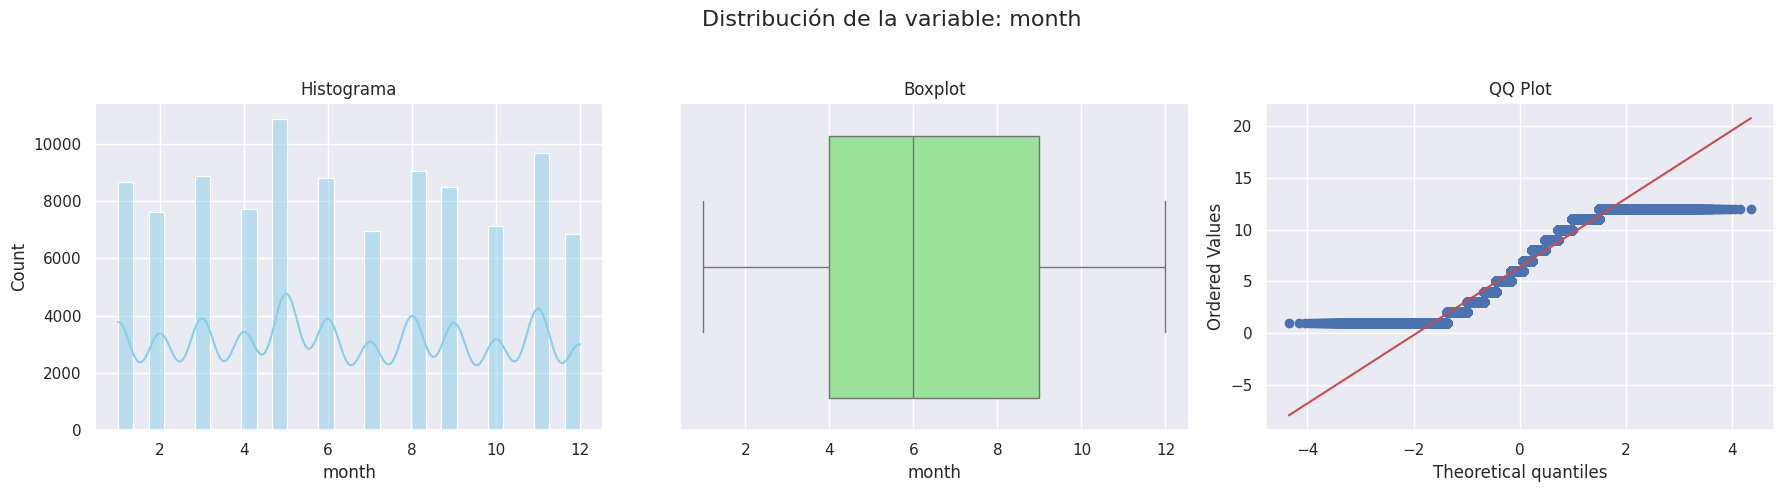

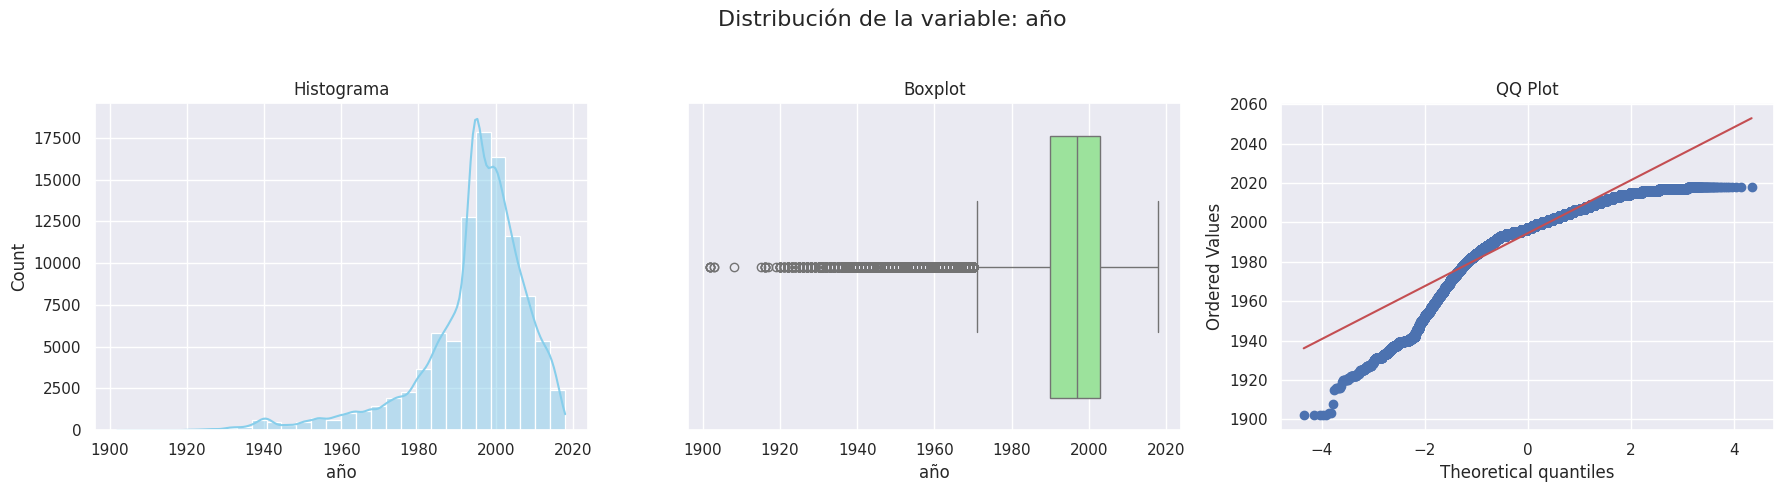

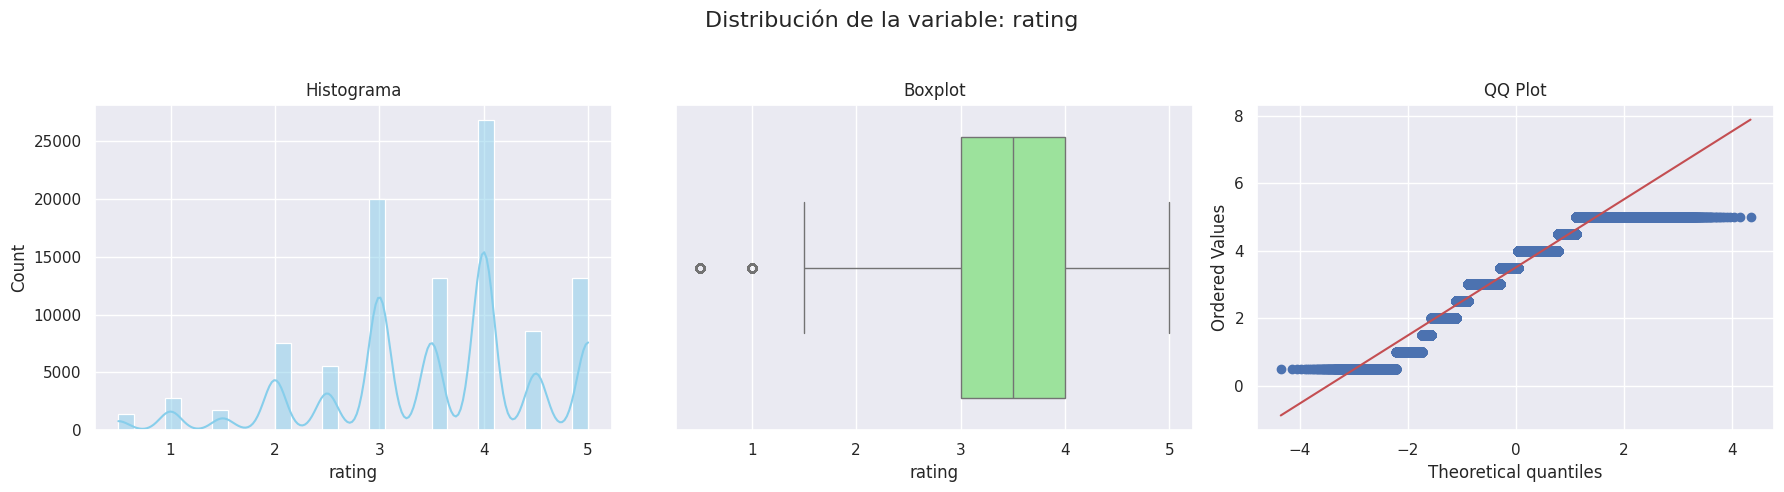

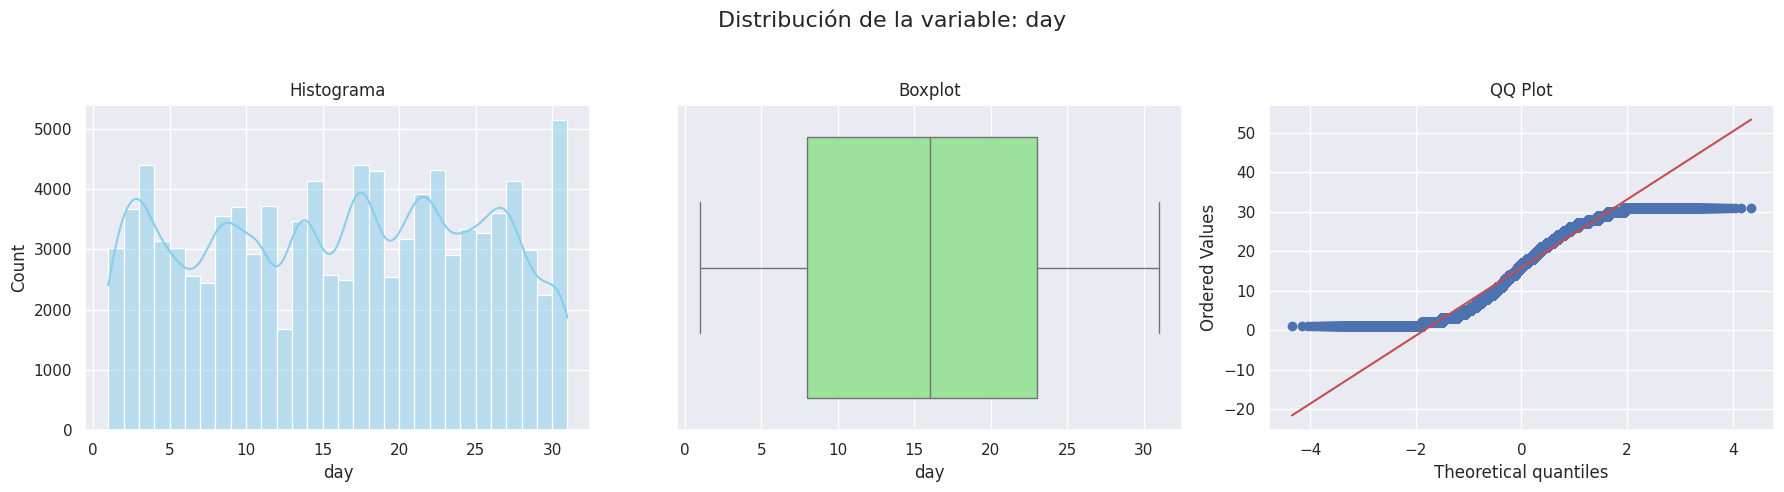

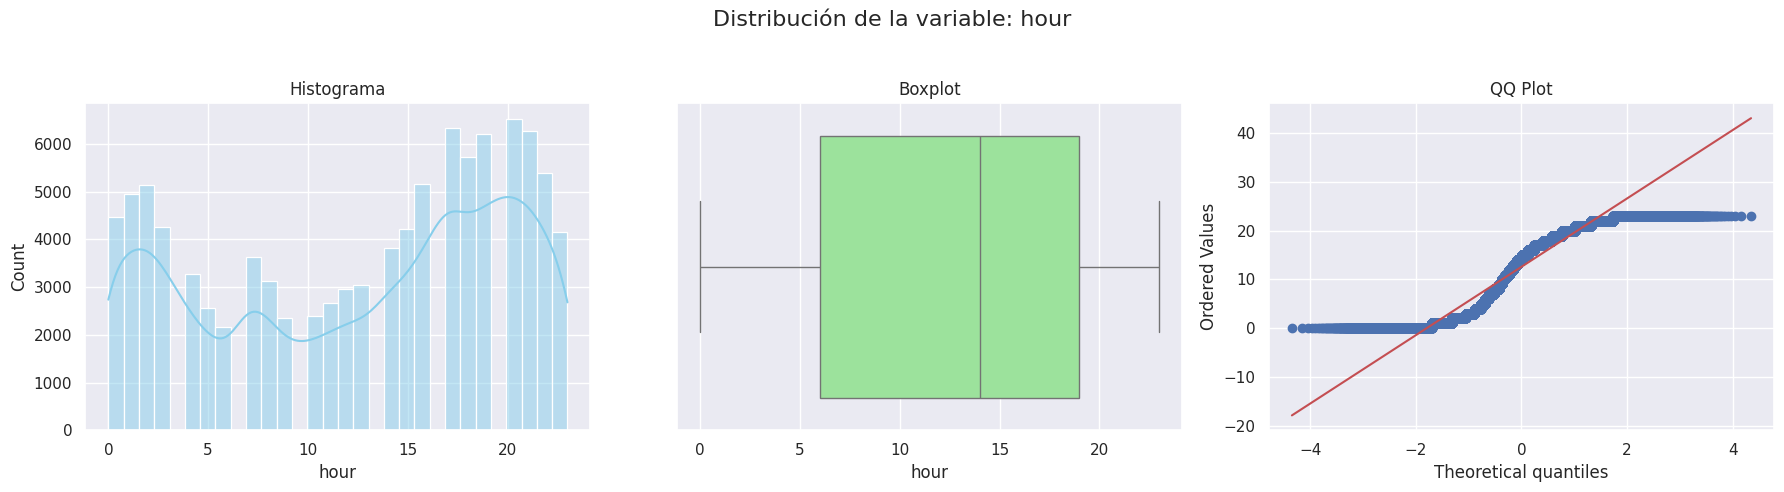

In [150]:
variables = ['year', 'month', 'año', 'rating', 'day', 'hour']
graficos_distribucion(df, variables)

In [268]:
# Descripsión estadistica de los datos.
pd.read_sql_query("""
SELECT
    'userId' AS columna,
    COUNT(userId) AS cantidad,
    AVG(userId) AS media,
    MIN(userId) AS minimo,
    MAX(userId) AS maximo
FROM ratings
UNION
SELECT
    'movieId' AS columna,
    COUNT(movieId),
    AVG(movieId),
    MIN(movieId),
    MAX(movieId)
FROM ratings
UNION
SELECT
    'rating' AS columna,
    COUNT(rating),
    AVG(rating),
    MIN(rating),
    MAX(rating)
FROM ratings
UNION
SELECT
    'day' AS columna,
    COUNT(day),
    AVG(day),
    MIN(day),
    MAX(day)
FROM ratings
UNION
SELECT
    'month' AS columna,
    COUNT(month),
    AVG(month),
    MIN(month),
    MAX(month)
FROM ratings
UNION
SELECT
    'hour' AS columna,
    COUNT(hour),
    AVG(hour),
    MIN(hour),
    MAX(hour)
FROM ratings
UNION
SELECT
    'year' AS columna,
    COUNT(year),
    AVG(year),
    MIN(year),
    MAX(year)
FROM ratings
""", conexion)


,columna,cantidad,media,minimo,maximo
0,day,100783,15.853894,1.0,31.0
1,hour,100783,12.608327,0.0,23.0
2,month,100783,6.414415,1.0,12.0
3,movieId,100783,19368.331415,1.0,193609.0
4,rating,100783,3.501573,0.5,5.0
5,userId,100783,326.127363,1.0,610.0
6,year,100783,2007.717958,1996.0,2018.0


In [269]:
#¿Hay calificaciones fuera del rango esperado (por ejemplo, menores a 0 o mayores a 5)?
query = """ SELECT *
FROM ratings
WHERE rating < 0 OR rating > 5
"""
pd.read_sql_query(query, conexion)

,userId,movieId,rating,day,month,hour,year


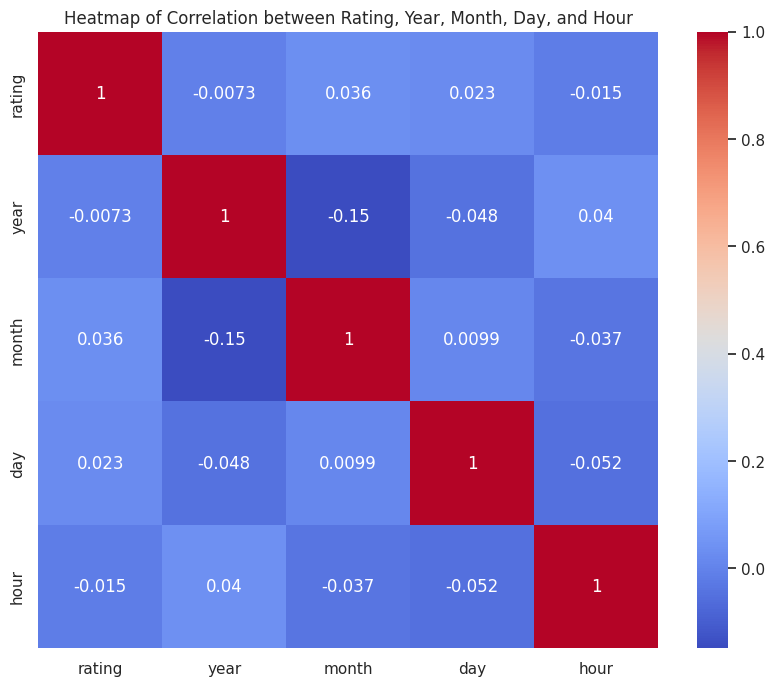

In [191]:
# Gráfica de calor - Correlacción entre las variables de la tabla ratings
plt.figure(figsize=(10, 8))
sns.heatmap(df[['rating', 'year', 'month', 'day', 'hour']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation between Rating, Year, Month, Day, and Hour')
plt.show()


#### ANÁLISIS EXPLORACIÓN EN CONJUNTO

In [270]:
# Realizar el INNER JOIN entre ratings y movies
query = """
SELECT r.userId,r.rating,r.day,r.month,r.hour,r.year, m.*
FROM ratings r
INNER JOIN movies m ON r.movieId = m.movieId
"""
df = pd.read_sql_query(query, conexion)

# Mostrar las primeras filas del DataFrame
df.head()

,userId,rating,day,month,hour,year,movieId,año,titulo,Action,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,4.0,30,7,18,2000,1,1995,Toy Story,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4.0,30,7,18,2000,3,1995,Grumpier Old Men,0,...,0,0,0,0,0,1,0,0,0,0
2,1,4.0,30,7,18,2000,6,1995,Heat,1,...,0,0,0,0,0,0,0,1,0,0
3,1,5.0,30,7,19,2000,47,1995,Seven (a.k.a. Se7en),0,...,0,0,0,0,1,0,0,1,0,0
4,1,5.0,30,7,18,2000,50,1995,"Usual Suspects, The",0,...,0,0,0,0,1,0,0,1,0,0


In [271]:
print(f"El tamaño de la tabla es de {df.shape[0]} filas y {df.shape[1]} columnas.")

El tamaño de la tabla es de 100783 filas y 28 columnas.


In [272]:
# Cuántos movieId únicos hay en cada tabla
ratings_ids = pd.read_sql_query("SELECT COUNT(DISTINCT movieId) AS total_ratings_ids FROM ratings", conexion)
movies_ids = pd.read_sql_query("SELECT COUNT(DISTINCT movieId) AS total_movies_ids FROM movies", conexion)

In [273]:
# Cuántos movieId de ratings están realmente en movies
matching_ids = pd.read_sql_query("""
SELECT COUNT(DISTINCT r.movieId) AS matching_ids
FROM ratings r
INNER JOIN movies m ON r.movieId = m.movieId
""", conexion)

ratings_ids, movies_ids, matching_ids

(   total_ratings_ids
 0               9685,
    total_movies_ids
 0              9703,
    matching_ids
 0          9685)



```
# Interpretación
  - Hay 9.703 películas únicas.
  - Hay 9.685 películas con al menos una calificación.
  - El INNER JOIN recuperó exactamente esas 9.685 coincidencias.
```





```
# INNER JOIN entre ratings y movies a través de movieId.
 De un total de 9.703 películas, 9.685 tienen calificaciones registradas.

 Por lo tanto, el INNER JOIN recupera todos los registros relevantes sin pérdidas de información importantes,
 y evita incluir películas sin datos de comportamiento del usuario.
```



In [274]:
#Guardar los cambios.
df.to_sql('ratings_movies', conexion, if_exists='replace', index=False)

100783

In [275]:
# Las primeras 10 películas con mayor cantidad de calificaciones.
query = """
SELECT m.titulo, COUNT(*) AS total_ratings, ROUND(AVG(r.rating), 2) AS avg_rating, m.año
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY r.movieId
ORDER BY total_ratings DESC
LIMIT 10
"""
pd.read_sql_query(query, conexion)


,titulo,total_ratings,avg_rating,año
0,Forrest Gump,329,4.16,1994
1,"Shawshank Redemption, The",317,4.43,1994
2,Pulp Fiction,307,4.20,1994
3,"Silence of the Lambs, The",279,4.16,1991
4,"Matrix, The",278,4.19,1999
5,Star Wars: Episode IV - A New Hope,251,4.23,1977
6,Jurassic Park,238,3.75,1993
7,Braveheart,237,4.03,1995
8,Terminator 2: Judgment Day,224,3.97,1991
9,Schindler's List,220,4.23,1993


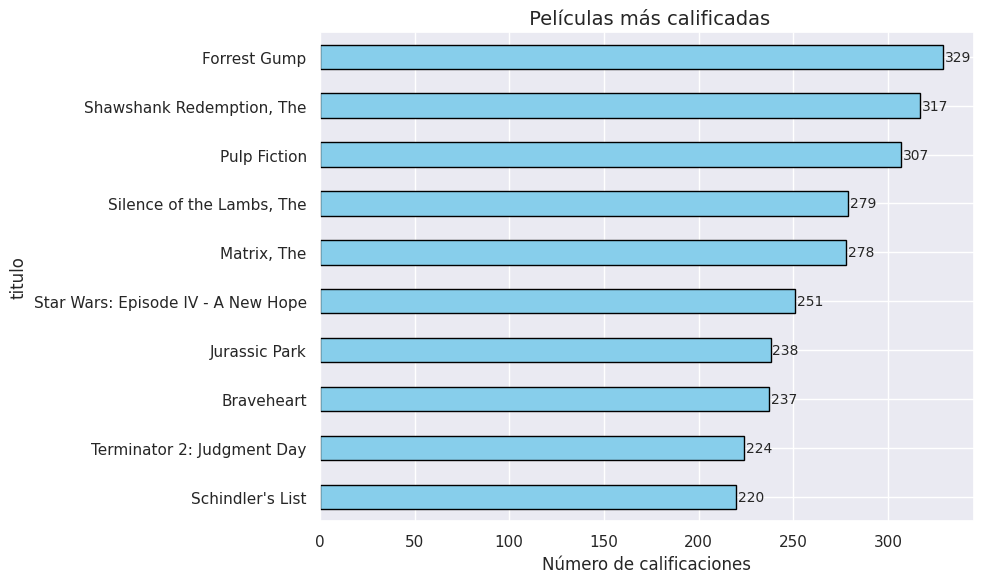

In [136]:
# Gráfica - Peliculas con mayor cantidad de calificaciones.

# Agrupar y seleccionar las 10 películas más calificadas
populares = df.groupby("titulo").size().sort_values(ascending=False).head(10)

# Crear figura
plt.figure(figsize=(10, 6))
bars = populares.plot(kind="barh", color="skyblue", edgecolor="black")
plt.title(" Películas más calificadas", fontsize=14)
plt.xlabel("Número de calificaciones")
plt.gca().invert_yaxis()

# Agregar etiquetas con valores en cada barra
for i, v in enumerate(populares.values):
    plt.text(v + 1, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()



```
# Las películas más calificadas y mejor valoradas pertenecen en su mayoría a la década de los 90.

Todas tienen un promedio de rating superior a 4, lo que refleja un alto
nivel de aprobación entre los usuarios.

clásicos como Star Wars (1977) y Schindler’s List (1993) siguen siendo
muy valorados, lo que demuestra su impacto duradero en el público.

```



In [276]:
# Los primeras 10 películas con la mejor calificación promedio y número de calificaciones.
query = """
SELECT m.titulo, COUNT(*) AS num_ratings, ROUND(AVG(r.rating), 2) AS avg_rating
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY r.movieId
HAVING COUNT(*) >= 10
ORDER BY avg_rating DESC
LIMIT 10
"""
pd.read_sql_query(query, conexion)


,titulo,num_ratings,avg_rating
0,Secrets & Lies,11,4.59
1,Guess Who's Coming to Dinner,11,4.55
2,Paths of Glory,12,4.54
3,"Streetcar Named Desire, A",20,4.48
4,"Celebration, The (Festen)",12,4.46
5,Ran,15,4.43
6,"Shawshank Redemption, The",317,4.43
7,His Girl Friday,14,4.39
8,All Quiet on the Western Front,10,4.35
9,"Hustler, The",18,4.33




```
# Las películas con mejores calificaciones promedio tienen menos calificaciones totales,
lo que sugiere que, aunque son altamente valoradas, han sido vistas
 y calificadas por un grupo más reducido de usuarios.
```



In [277]:
# Cantidad de generos por los primeros años.
query = """SELECT m.año,
    SUM(Action) AS Action,
    SUM(Comedy) AS Comedy,
    SUM(Drama) AS Drama,
    SUM(Horror) AS Horror,
    SUM(Romance) AS Romance,
    SUM(Thriller) AS Thriller,
    SUM(Adventure) AS Adventure,
    SUM(Animation) AS Animation,
    SUM(Children) AS Children,
    SUM(Documentary) AS Documentary,
    SUM(Fantasy) AS Fantasy,
    SUM(IMAX) AS IMAX,
    SUM(Musical) AS Musical,
    SUM(Mystery) AS Mystery,
    SUM(War) AS War,
    SUM(Western) AS Western,
    SUM("Film-Noir") AS "Film-Noir",
    SUM("Sci-Fi") AS "Sci-Fi"
FROM movies m
GROUP BY m.año
ORDER BY m.año ASC

limit 10
"""
pd.read_sql_query(query, conexion)

,año,Action,Comedy,Drama,Horror,Romance,Thriller,Adventure,Animation,Children,Documentary,Fantasy,IMAX,Musical,Mystery,War,Western,Film-Noir,Sci-Fi
0,1902,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
1,1903,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1908,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,1915,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1916,1,1,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1
5,1917,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1919,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1920,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8,1921,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,1922,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0




```
# Durante las primeras décadas del cine (1902–1922),
se observa una diversidad limitada de géneros, con predominio de
películas Drama, Comedy, y Sci-Fi.
```



In [186]:
# Cantidad de generos por los últimos años.
query = """SELECT m.año,
    SUM(Action) AS Action,
    SUM(Comedy) AS Comedy,
    SUM(Drama) AS Drama,
    SUM(Horror) AS Horror,
    SUM(Romance) AS Romance,
    SUM(Thriller) AS Thriller,
    SUM(Adventure) AS Adventure,
    SUM(Animation) AS Animation,
    SUM(Children) AS Children,
    SUM(Documentary) AS Documentary,
    SUM(Fantasy) AS Fantasy,
    SUM(IMAX) AS IMAX,
    SUM(Musical) AS Musical,
    SUM(Mystery) AS Mystery,
    SUM(War) AS War,
    SUM(Western) AS Western,
    SUM("Film-Noir") AS "Film-Noir",
    SUM("Sci-Fi") AS "Sci-Fi"
FROM movies m
GROUP BY m.año
ORDER BY m.año DESC

limit 10
"""
pd.read_sql_query(query, conexion)

,año,Action,Comedy,Drama,Horror,Romance,Thriller,Adventure,Animation,Children,Documentary,Fantasy,IMAX,Musical,Mystery,War,Western,Film-Noir,Sci-Fi
0,2018,17,17,9,4,1,14,12,3,3,2,7,0,0,5,0,0,0,14
1,2017,38,56,45,13,6,22,24,18,9,10,14,0,0,6,3,2,0,18
2,2016,48,75,71,16,18,42,36,22,13,13,22,0,0,8,3,1,0,29
3,2015,63,104,101,36,21,57,45,19,14,19,21,1,1,16,2,4,0,41
4,2014,62,116,117,28,35,60,35,15,15,17,15,14,5,16,8,3,0,32
5,2013,61,89,98,22,27,50,39,26,8,8,28,29,1,14,6,1,0,32
6,2012,56,103,92,27,31,54,31,25,10,11,23,25,7,9,5,1,1,28
7,2011,55,101,110,20,37,64,40,26,19,22,19,20,3,16,6,2,2,32
8,2010,65,97,102,24,41,56,30,18,17,17,29,15,6,16,7,5,1,19
9,2009,59,111,131,41,41,72,37,32,17,12,32,10,7,24,7,2,1,44




```
# Se observa un aumento general en la cantidad de películas producidas en
todos los géneros, con una especial expansión en géneros como Comedy, Drama, y Thriller.
```



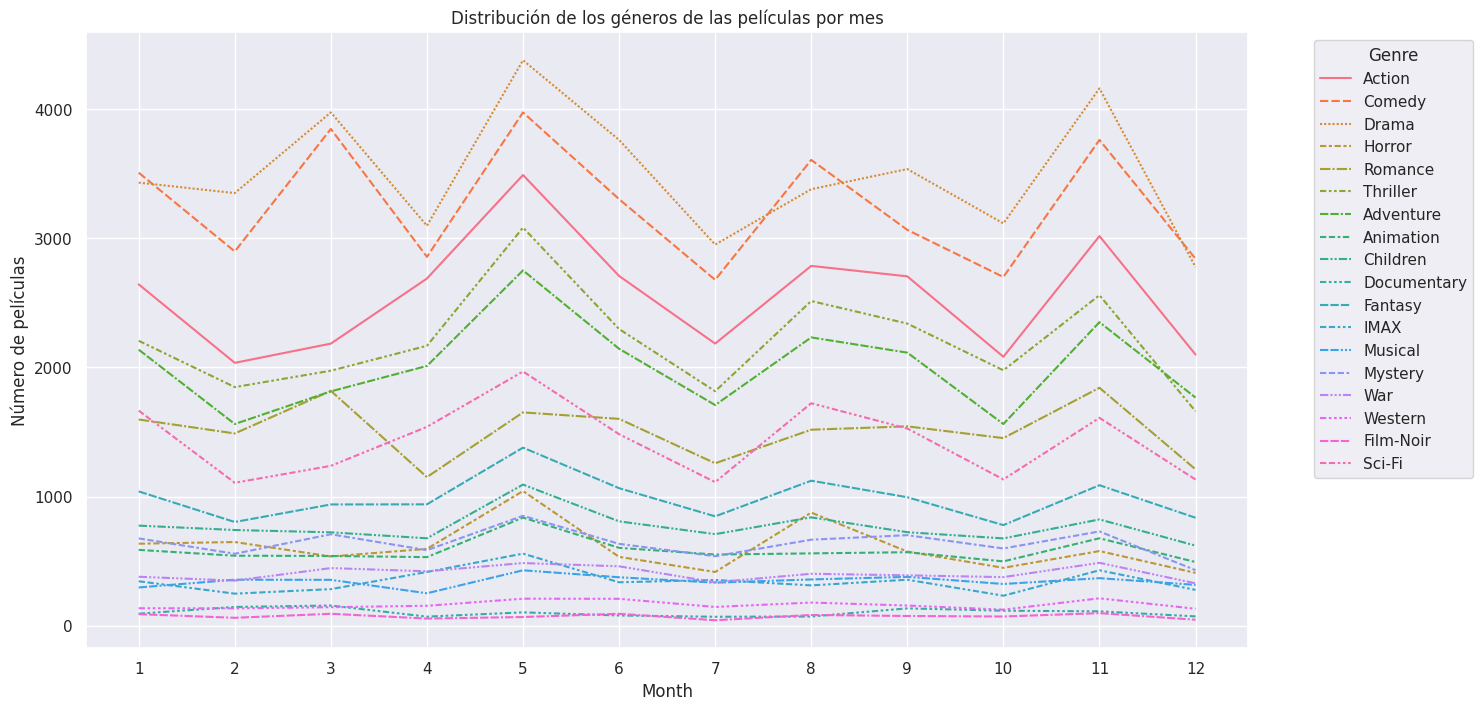

In [190]:
# Frecuencias de género por mes.
genre_by_month = df.groupby('month')[genre_columns].sum()

# Create the plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=genre_by_month)
plt.title('Distribución de los géneros de las películas por mes')
plt.xlabel('Month')
plt.ylabel('Número de películas')
plt.xticks(range(1, 13))  # Set x-axis ticks to represent months (1 to 12)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
plt.show()
